In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage as sk
import skimage.io as skio
from PIL import ImageEnhance

In [2]:
def ncc(matA, matB):
    sum = 0
    for y in range(0, matA.shape[0]):
        matAVec = matA[y, :]
        matBVec = matB[y, :]
        aNorm = np.linalg.norm(matAVec)
        bNorm = np.linalg.norm(matBVec)
        sum += np.dot(np.divide(matAVec, aNorm), np.divide(matBVec, bNorm, where= bNorm!=0))
        
    for x in range(0, matA.shape[1]):
        matAVec = matA[:, x]
        matBVec = matB[:, x]
        aNorm = np.linalg.norm(matAVec)
        bNorm = np.linalg.norm(matBVec)
        sum += np.dot(np.divide(matAVec, aNorm), np.divide(matBVec, bNorm, where= bNorm!=0))
    return sum

def shift_frame(x_shift, y_shift, matA, zeroPad = False):
    if x_shift < 0:
        if y_shift < 0:
            return np.pad(matA[:y_shift, :x_shift], ((0, -y_shift), (0, -x_shift)), mode="constant") if zeroPad else matA[:y_shift, :x_shift]
        else:
            return np.pad(matA[y_shift: ,:x_shift], ((y_shift, 0), (0, -x_shift)), mode="constant") if zeroPad else matA[y_shift: ,:x_shift]
    else:
        if y_shift < 0:
            return np.pad(matA[:y_shift ,x_shift:], ((0, -y_shift), (x_shift, 0)), mode="constant") if zeroPad else matA[:y_shift ,x_shift:]
        else:
            return np.pad(matA[y_shift: ,x_shift:], ((y_shift, 0), (x_shift, 0)), mode="constant") if zeroPad else matA[y_shift: ,x_shift:]

In [3]:
def find_shift(baseFrame, layerFrame):
    shift = []
    bestFrame = []
    maxCorr = 0
    xRange = np.floor(r_cropped.shape[1] * 0.05).astype(int)
    yRange = np.floor(r_cropped.shape[0] * 0.05).astype(int)
    print("roll range x/y:", xRange, yRange)
    
    for y in range(-yRange, yRange+1):
        yShifted = np.roll(layerFrame, y, axis=0)
        for x in range(-xRange, xRange+1):
            xShifted = np.roll(yShifted, x, axis=1)
            layerFrameCropped = shift_frame(x, y, xShifted)
            baseFrameCropped = shift_frame(x, y, baseFrame)
            corrScore = ncc(baseFrameCropped, layerFrameCropped)
            
            if corrScore > maxCorr:
                maxCorr = corrScore
                # print(corrScore)
                bestFrame = [baseFrameCropped, layerFrameCropped]
                shift.append([x,y])
             
    matchedFrame = np.stack((bestFrame[0], np.empty_like(bestFrame[0]), np.empty_like(bestFrame[0])), axis=2)   
    # matchedFrame = cv2.normalize(np.sum(bestFrame, axis=0), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # fig, axs = plt.subplots(1, 2, figsize=(20, 30))
    # axs[0].imshow(bestFrame[0], cmap='gray', vmin=0, vmax=1)
    # axs[1].imshow(bestFrame[1], cmap='gray', vmin=0, vmax=1)
    # plt.show()
    return shift
    

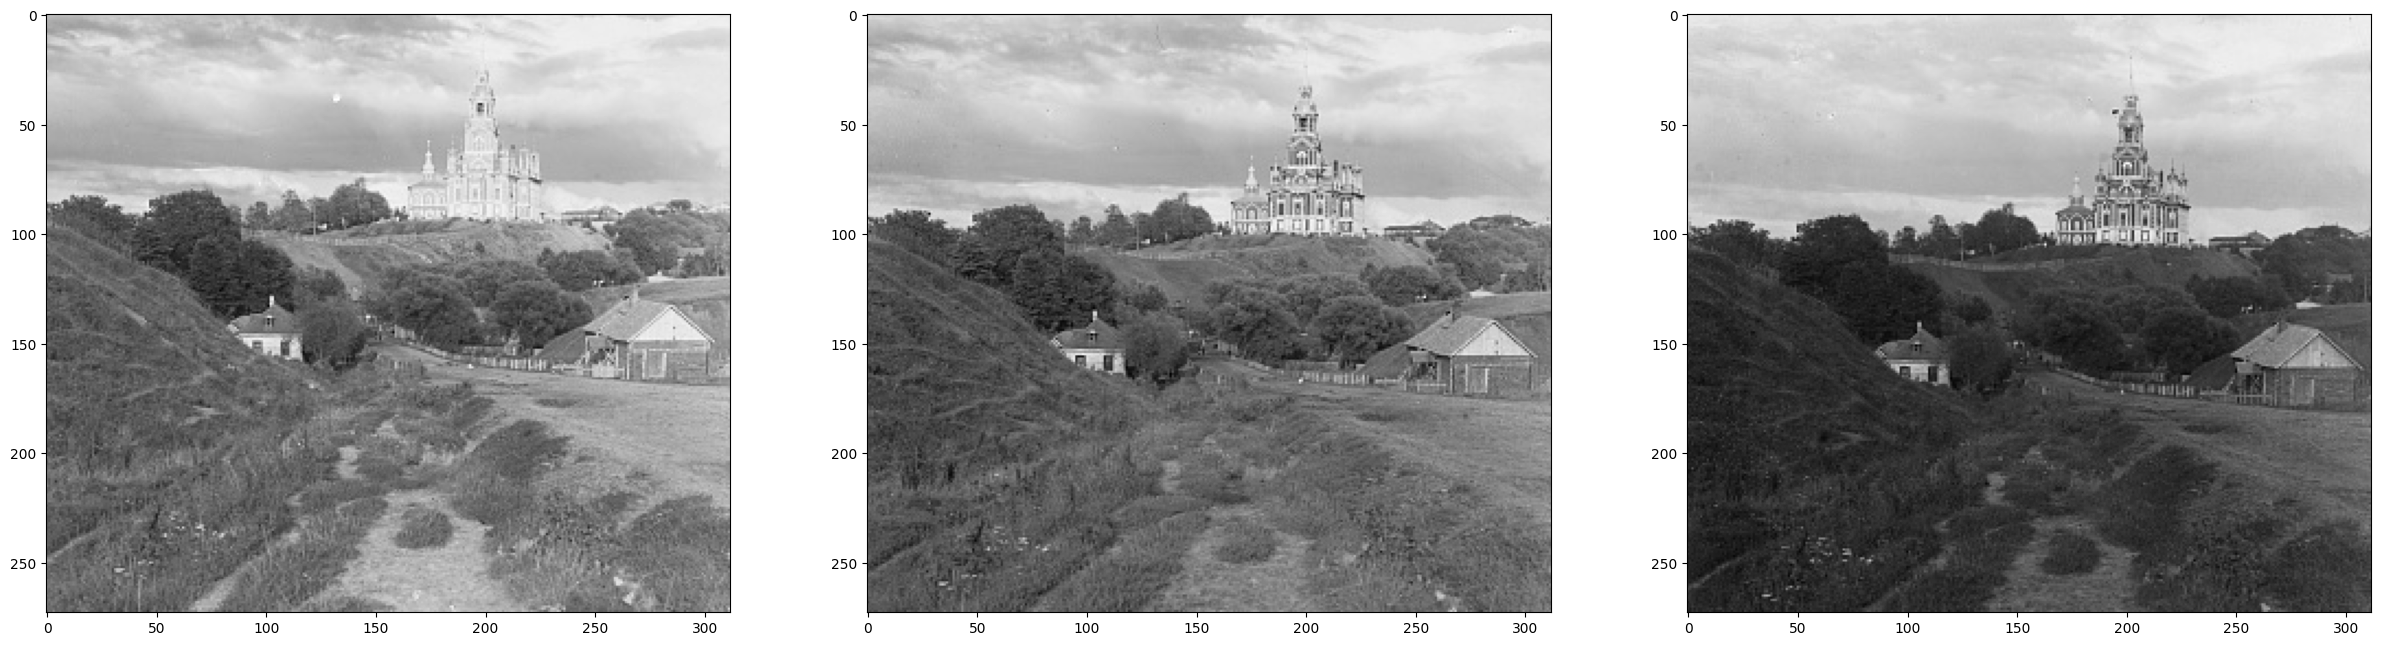

In [13]:
# name of the input file
imname = './data/cathedral.jpg'

# read in the image
im = skio.imread(imname, cv2.IMREAD_GRAYSCALE)
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

v_border = int(r.shape[0]*0.1)
h_border = int(r.shape[1]*0.1)
r_cropped = sk.util.img_as_float(r[v_border:-v_border, h_border:-h_border])
b_cropped = sk.util.img_as_float(b[v_border:-v_border, h_border:-h_border])
g_cropped = sk.util.img_as_float(g[v_border:-v_border, h_border:-h_border])
rgb = np.array([r_cropped, g_cropped, b_cropped])

for i in range(0, 3):
    img_adj = rgb[i]
    # blackpoint = np.percentile(img_adj, 1)
    # print(blackpoint)
    # img_adj = np.clip(img_adj - blackpoint, 0, 1).astype(np.float64)
    # 
    # img_adj = 1 - img_adj
    # img_adj = 1.2 * img_adj + 0.02
    # img_adj = 1 - img_adj

    rgb[i] = cv2.normalize(img_adj, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
r_cropped = rgb[0]
g_cropped = rgb[1]
b_cropped = rgb[2]

fig, axs = plt.subplots(1, 3, figsize=(30, 40))
axs[0].imshow(r_cropped, cmap='gray', vmin=0, vmax=1)
axs[1].imshow(g_cropped, cmap='gray', vmin=0, vmax=1)
axs[2].imshow(b_cropped, cmap='gray', vmin=0, vmax=1)
plt.show()

In [14]:
baseFrame = r_cropped
shift = []
shift.append(find_shift(b_cropped, g_cropped))
shift.append(find_shift(b_cropped, r_cropped))
    
print(shift[0][-1], shift[1][-1])

roll range x/y: 15 13
roll range x/y: 15 13
[2, 5] [3, 12]


(273, 312) (273, 312) (273, 312)


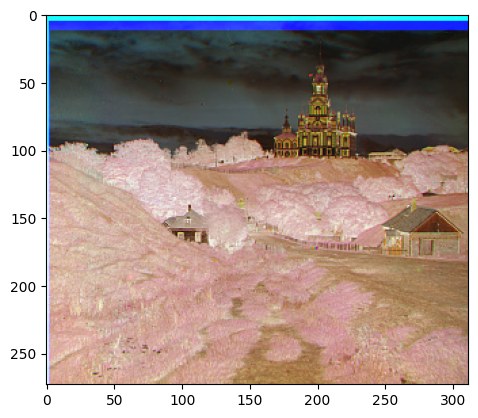

In [15]:
finalShift = np.array([shift[0][-1], shift[1][-1]])

b = b_cropped
g = shift_frame(finalShift[0, 0], finalShift[0, 1], np.roll(g_cropped, (finalShift[0, 0], finalShift[0, 1]), axis=(1, 0)), zeroPad=True)
r = shift_frame(finalShift[1, 0], finalShift[1, 1], np.roll(r_cropped, (finalShift[1, 0], finalShift[1, 1]), axis=(1, 0)), zeroPad=True)
print(r.shape, g.shape, b.shape)
# fig, axs = plt.subplots(1, 3, figsize=(20, 30))
# axs[0].imshow(b, cmap='gray', vmin=0, vmax=1)
# axs[1].imshow(g, cmap='gray', vmin=0, vmax=1)
# axs[2].imshow(r, cmap='gray', vmin=0, vmax=1)
# plt.show()

bgr = np.array([b,g,r])
colorized= 1- np.stack((b,g,r), axis=2)
# converter = ImageEnhance.Color(image=colorized)
# enhanced = converter.enhance(1.5)
plt.imshow(colorized)

In [16]:
maxShifts = np.clip(np.max(finalShift, axis=0), a_min = 0, a_max = None)
minShifts = np.clip(np.max(finalShift, axis=0), a_min = None, a_max = 0)

if minShifts[0] < 0:
    if minShifts[1] < 0:
        bgr = bgr[:, maxShifts[1]:minShifts[1], maxShifts[0]:minShifts[0]]
    else:
        bgr = bgr[:, maxShifts[1]:, maxShifts[0]:minShifts[0]]
else:
    if minShifts[1] < 0:
        bgr = bgr[:, maxShifts[1]:minShifts[1], maxShifts[0]:]
    else:
        bgr = bgr[:, maxShifts[1]:, maxShifts[0]:]

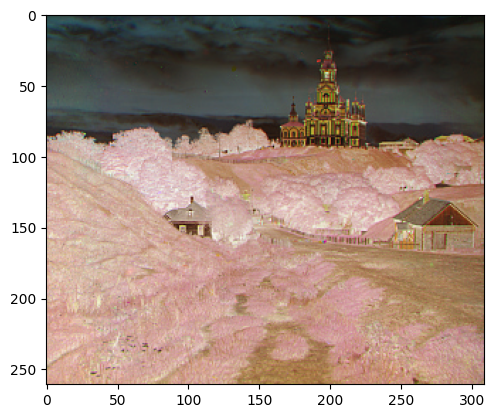

In [17]:
# colorized = (1 - np.stack((bgr[0],bgr[1],bgr[2]), axis=2))
colorized = (1 - np.stack((bgr[0],bgr[1],bgr[2]), axis=2))
colorized = cv2.normalize(colorized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
plt.imshow(colorized)